<a href="https://colab.research.google.com/github/mahera02/machine_learning/blob/master/HW2/Best_Architecture_K_fold_4_cifar10_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 data set

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os
import time
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Loading the CIFAR10 data set

In [2]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# shuffling the images after loading
train_images, train_labels = shuffle(train_images, train_labels, random_state=0)


170500096/170498071 [==============================] - 14s 0us/step


# Architecture 4

**Initialize Parameters**

In [0]:
batch_size = 128
num_classes = 10
epochs = 125
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'arch4_keras_cifar10_trained_model.h5'

**Definition for Training and Loss Plots**

In [0]:
def plot_model_history(history):
   acc = history.history['acc']
   val_acc = history.history['val_acc']
  
   loss = history.history['loss']
   val_loss = history.history['val_loss']

   epochs = range(1, len(acc) + 1)

   # training and validation accuracy
  
   plt.title("Model Accuracy")
   plt.xlabel('Epoch')
   plt.ylabel('Accuracy')
   plt.plot(epochs, acc,  label='training acc')
   plt.plot(epochs, val_acc, label='validation acc')
   plt.legend()

   plt.figure()

   # training and validation loss
  
   plt.title("Model Loss")
   plt.xlabel('Epoch')
   plt.ylabel('Loss')
   plt.plot(epochs, loss,label='training loss')
   plt.plot(epochs, val_loss,label='validation loss')
   plt.legend()

   plt.show()

**Model Definition**

In [0]:
def model(train_images,train_labels,test_images,test_labels):
 
  print('train_images shape:', train_images.shape)
  print(train_images.shape[0], 'train samples')
  print(test_images.shape[0], 'test samples')
  
  model = Sequential()
  
  # Layer 1
  model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_images.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  # Layer 2
  model.add(Conv2D(32, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  # Layer 3
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  # Layer 4
  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))
  
   # Layer 5
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  # Layer 6
  model.add(Conv2D(128, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.4))
  
  # dense layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  #model.summary()
  
  # Augmenting training set images
  train_datagen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=False)
  train_datagen.fit(train_images)
  
  # initiate RMSprop optimizer
  opt = keras.optimizers.rmsprop(lr=0.0003, decay=1e-6)

  # Let's train the model using RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  
  start = time.time()
                
  model_history = model.fit_generator(train_datagen.flow(train_images, train_labels, batch_size=batch_size),steps_per_epoch = train_images.shape[0]/batch_size, epochs = epochs, 
                verbose = 1,validation_data = (test_images, test_labels) )          
                
  end = time.time()
  
  # Score trained model.
  scores = model.evaluate(test_images, test_labels, batch_size=128, verbose=1)
  print('Test loss:', scores[0])
  print("Test accuracy: %.2f%%" % (scores[1]*100))
  
  # plot model history
  plot_model_history(model_history)
  print("Model took %0.2f seconds to train" % (end - start))
    
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)
  
  return model , scores

**Data Pre-Processing and Splitting the train_images to validation set (80:20) using K-fold validation**

In [0]:
def kfold(k,X_folds,y_folds):
    # We use 'list' to copy, in order to 'pop' later on
    X_train = list(X_folds)
    X_val = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_val = y_train.pop(k)
    y_train = np.concatenate(y_train)
    
    image=X_val[1]
    plt.figure(figsize=(2, 2))
    plt.grid(None)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.show()
    
    # reshape train and val images 
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_train /= 255
    X_val /= 255

    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    
  
    return X_train,y_train,X_val,y_val

**FOLD 1**

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


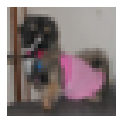

train_images shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/125
313/312 [==============================] - 33s 104ms/step - loss: 2.0664 - acc: 0.2822 - val_loss: 1.7010 - val_acc: 0.3829
Epoch 2/125
313/312 [==============================] - 26s 84ms/step - loss: 1.6433 - acc: 0.4054 - val_loss: 1.4431 - val_acc: 0.4761
Epoch 3/125
313/312 [==============================] - 26s 85ms/step - loss: 1.4725 - acc: 0.4644 - val_loss: 1.3762 - val_acc: 0.5056
Epoch 4/125
313/312 [==============================] - 27s 86ms/step - loss: 1.3449 - acc: 0.5190 - val_loss: 1.2275 - val_acc: 0.5751
Epoch 5/125
313/312 [==============================] - 26s 84ms/step - loss: 1.2498 - acc: 0.5511 - val_loss: 1.2429 - val_acc: 0.5707
Epoch 6/125

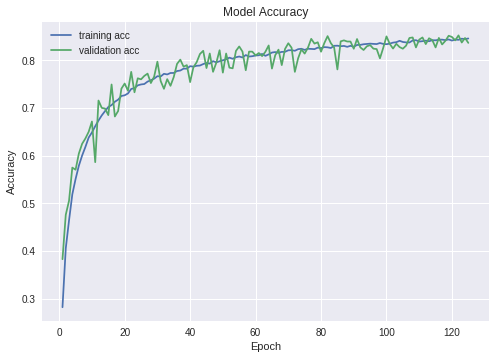

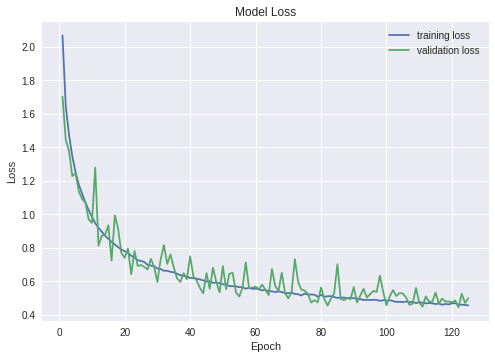

Model took 3274.11 seconds to train
Saved trained model at /content/saved_models/arch4_keras_cifar10_trained_model.h5 


In [7]:
#from sklearn.model_selection import train_test_split

#train_images, image_val, train_labels, label_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=1)

scoreslist = list()

import numpy as np
X_folds = np.array_split(train_images, 5)
print(X_folds[0].shape)
print(X_folds[1].shape)
print(X_folds[2].shape)
print(X_folds[3].shape)
print(X_folds[4].shape)
y_folds = np.array_split(train_labels, 5)

#get the new training and validation set on every fold by calling kfold
X_train,y_train,X_val,y_val = kfold(0,X_folds,y_folds)


#call model using X_train and y_train
model_result ,scores = model(X_train,y_train,X_val,y_val)
scoreslist.append(scores[1]*100)


**FOLD 2**

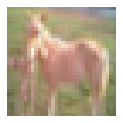

train_images shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
Epoch 1/125
313/312 [==============================] - 29s 93ms/step - loss: 2.0628 - acc: 0.2932 - val_loss: 1.4719 - val_acc: 0.4581
Epoch 2/125
313/312 [==============================] - 26s 83ms/step - loss: 1.6348 - acc: 0.4101 - val_loss: 1.8019 - val_acc: 0.3880
Epoch 3/125
313/312 [==============================] - 25s 81ms/step - loss: 1.4448 - acc: 0.4766 - val_loss: 1.3765 - val_acc: 0.5179
Epoch 4/125
313/312 [==============================] - 26s 84ms/step - loss: 1.3186 - acc: 0.5235 - val_loss: 1.5898 - val_acc: 0.4699
Epoch 5/125
313/312 [==============================] - 25s 81ms/step - loss: 1.2293 - acc: 0.5593 - val_loss: 1.4805 - val_acc: 0.5201
Epoch 6/125
313/312 [==============================] - 26s 83ms/step - loss: 1.1618 - acc: 0.5845 - val_loss: 1.4679 - val_acc: 0.5335
Epoch 7/125
313/312 [==============================] - 25s 80ms/step - loss: 1.1063 - acc: 0.6071 - val_loss: 1.

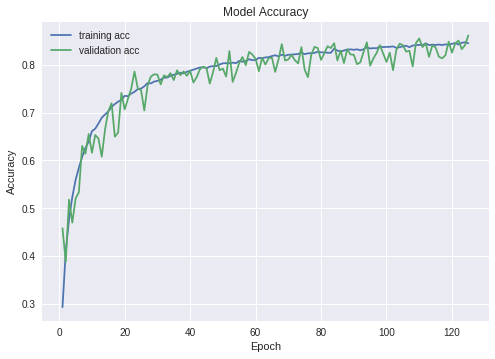

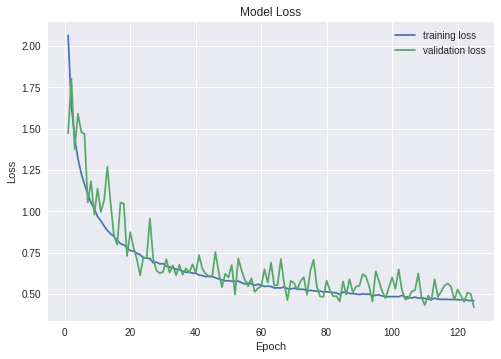

Model took 3231.44 seconds to train
Saved trained model at /content/saved_models/arch4_keras_cifar10_trained_model.h5 


In [8]:
X_train,y_train,X_val,y_val = kfold(1,X_folds,y_folds)

#call model using X_train and y_train
model_result ,scores = model(X_train,y_train,X_val,y_val)
scoreslist.append(scores[1]*100)

**FOLD 3**

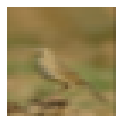

train_images shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
Epoch 1/125
313/312 [==============================] - 27s 87ms/step - loss: 2.0513 - acc: 0.2863 - val_loss: 1.6908 - val_acc: 0.3917
Epoch 2/125
313/312 [==============================] - 25s 81ms/step - loss: 1.6366 - acc: 0.4067 - val_loss: 1.3813 - val_acc: 0.4920
Epoch 3/125
313/312 [==============================] - 24s 77ms/step - loss: 1.4667 - acc: 0.4718 - val_loss: 1.3901 - val_acc: 0.5160
Epoch 4/125
313/312 [==============================] - 24s 78ms/step - loss: 1.3368 - acc: 0.5197 - val_loss: 1.3568 - val_acc: 0.5207
Epoch 5/125
313/312 [==============================] - 24s 77ms/step - loss: 1.2495 - acc: 0.5519 - val_loss: 1.1436 - val_acc: 0.5957
Epoch 6/125
313/312 [==============================] - 25s 81ms/step - loss: 1.1637 - acc: 0.5853 - val_loss: 1.3575 - val_acc: 0.5508
Epoch 7/125
313/312 [==============================] - 24s 77ms/step - loss: 1.0996 - acc: 0.6093 - val_loss: 1.

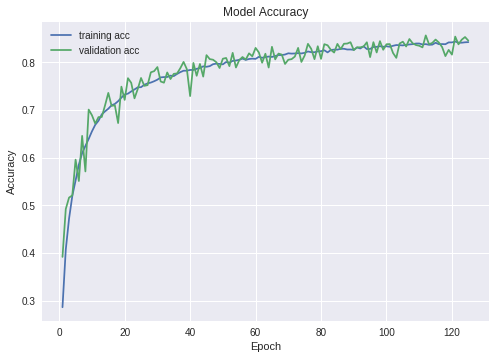

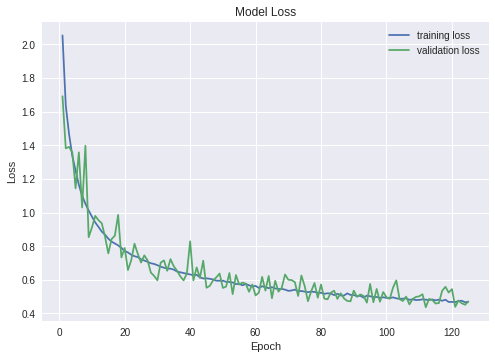

Model took 3113.45 seconds to train
Saved trained model at /content/saved_models/arch4_keras_cifar10_trained_model.h5 


In [9]:
X_train,y_train,X_val,y_val = kfold(2,X_folds,y_folds)

#call model using X_train and y_train
model_result ,scores = model(X_train,y_train,X_val,y_val)
scoreslist.append(scores[1]*100)

**FOLD 4**

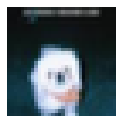

train_images shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
Epoch 1/125
313/312 [==============================] - 28s 89ms/step - loss: 2.0907 - acc: 0.2808 - val_loss: 1.6355 - val_acc: 0.4092
Epoch 2/125
313/312 [==============================] - 25s 81ms/step - loss: 1.6581 - acc: 0.4018 - val_loss: 1.4162 - val_acc: 0.4935
Epoch 3/125
313/312 [==============================] - 25s 80ms/step - loss: 1.4728 - acc: 0.4666 - val_loss: 1.5551 - val_acc: 0.4739
Epoch 4/125
313/312 [==============================] - 25s 80ms/step - loss: 1.3395 - acc: 0.5187 - val_loss: 1.8228 - val_acc: 0.4351
Epoch 5/125
313/312 [==============================] - 24s 78ms/step - loss: 1.2475 - acc: 0.5492 - val_loss: 1.0496 - val_acc: 0.6149
Epoch 6/125
313/312 [==============================] - 25s 80ms/step - loss: 1.1782 - acc: 0.5782 - val_loss: 1.2372 - val_acc: 0.5632
Epoch 7/125
313/312 [==============================] - 24s 78ms/step - loss: 1.1181 - acc: 0.6012 - val_loss: 1.

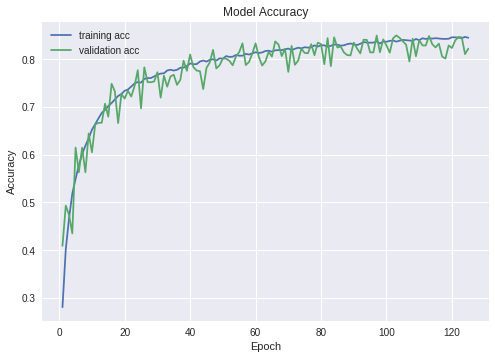

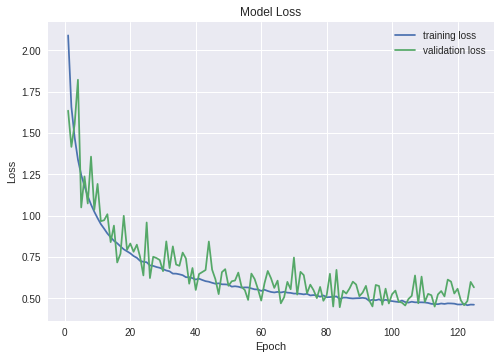

Model took 3205.65 seconds to train
Saved trained model at /content/saved_models/arch4_keras_cifar10_trained_model.h5 


In [10]:
X_train,y_train,X_val,y_val = kfold(3,X_folds,y_folds)

#call model using X_train and y_train
model_result ,scores = model(X_train,y_train,X_val,y_val)
scoreslist.append(scores[1]*100)

**FOLD 5**

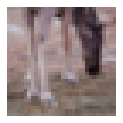

train_images shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
Epoch 1/125
313/312 [==============================] - 28s 89ms/step - loss: 2.1089 - acc: 0.2742 - val_loss: 1.7063 - val_acc: 0.3798
Epoch 2/125
313/312 [==============================] - 25s 79ms/step - loss: 1.6709 - acc: 0.3974 - val_loss: 1.5850 - val_acc: 0.4294
Epoch 3/125
313/312 [==============================] - 25s 79ms/step - loss: 1.4814 - acc: 0.4607 - val_loss: 1.6808 - val_acc: 0.4555
Epoch 4/125
313/312 [==============================] - 26s 82ms/step - loss: 1.3484 - acc: 0.5132 - val_loss: 1.2690 - val_acc: 0.5444
Epoch 5/125
313/312 [==============================] - 25s 79ms/step - loss: 1.2489 - acc: 0.5517 - val_loss: 1.4726 - val_acc: 0.5012
Epoch 6/125
313/312 [==============================] - 24s 77ms/step - loss: 1.1756 - acc: 0.5796 - val_loss: 1.5813 - val_acc: 0.4998
Epoch 7/125
313/312 [==============================] - 25s 80ms/step - loss: 1.1070 - acc: 0.6029 - val_loss: 1.

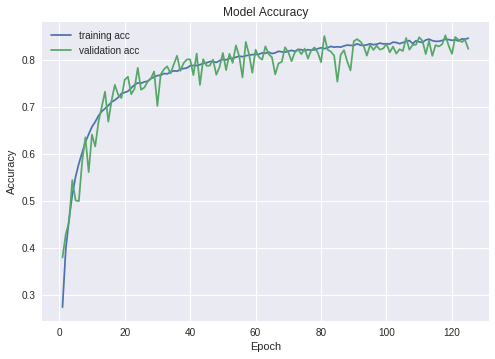

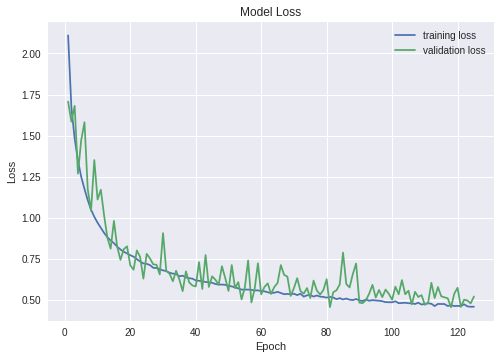

Model took 3255.90 seconds to train
Saved trained model at /content/saved_models/arch4_keras_cifar10_trained_model.h5 


In [11]:
X_train,y_train,X_val,y_val = kfold(4,X_folds,y_folds)

#call model using X_train and y_train
model_result ,scores = model(X_train,y_train,X_val,y_val)
scoreslist.append(scores[1]*100)

**AVERAGE ACCURACY AFTER K-FOLD VALIDATION**

In [12]:
print('scorelist of validation accuracy on 5 folds ',scoreslist)
mean_accuracy = np.mean(scoreslist)
print('Mean accuracy of K-fold validation ',mean_accuracy)

 

scorelist of validation accuracy on 5 folds  [83.69, 86.13, 84.54, 82.21000000000001, 82.35]
Mean accuracy of K-fold validation  83.78400000000002


**Performance of the Architecture on the test set**

In [13]:
# reshape original test images 
test_images = test_images.astype('float32')
test_images /= 255

# Convert class vectors to binary class matrices.
test_labels = keras.utils.to_categorical(test_labels, num_classes)
 
scores = model_result.evaluate(test_images, test_labels,batch_size=128, verbose=1)
print('Test loss:', scores[0])
print("Test accuracy: %.2f%%" % (scores[1]*100))

10000/10000 [==============================] - 1s 112us/step
Test loss: 0.528063433265686
Test accuracy: 82.20%


**Architecture Description**

In this architecture I have trained the dataset with simple hold out validation [ training set (80%) validation set (20%) ] for 125 epochs, batch size 128 and six convolutiton layers with Dropout and BatchNormalization and DataAugmentation. The learning rate is .0003 and. The mean accuracy after applying k-fold validation to the model is 83.78%. The accuracy plot is also not overfitting.

Its performance on the original test data set is 82.20%

**Comparison of accuracy/loss obtained by k-fold validation with the accuracy/loss obtain by simple hold-out validation**


1.   Simple hold-out validation

           *   Accuracy - 85.15% 
           *   Loss - 0.48
           *   Evaluation on Test data - 84.27%
           


2.   k-fold validation

          *   Accuracy - 83.78%
          *   Loss - 0.5
          *   Evaluation on Test data - 82.20%



